# Dataset Generation: random_variations_v2 Dataset


## Imports


In [1]:
from copy import deepcopy
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from simcats import Simulation, default_configs
from simcats.distortions import (
    OccupationDotJumps,
    OccupationTransitionBlurringFermiDirac,
    SensorPotentialPinkNoise,
    SensorPotentialRTN,
    SensorResponseRTN,
    SensorResponseWhiteNoise,
)
from simcats.sensor import SensorGeneric, SensorInterface, SensorPeakLorentzian
from simcats.support_functions import (
    NormalSamplingRange,
    ExponentialSamplingRange,
    plot_csd,
    rotate_points,
)

from simcats_datasets.generation import create_simulated_dataset
from simcats_datasets.loading import load_dataset

DIPlib -- a quantitative image analysis library
Version 3.4.1 (Oct 13 2023)
For more information see https://diplib.org


## Dataset Config

Configurations for the generation of the dataset. 


In [2]:
num_configs = 1000  # number of different configs to be sampled
num_samples_per_config = 100  #  number of CSDs to be generated per config
resolution = np.array([96, 96])  # resolution (in pixels) of the generated CSDs given as [res_g1, re_g2] ([res_x, res_y])
volt_range = np.array([0.03 * 0.96, 0.03 * 0.96])  # volt_range of the generated CSDs
lut_entries = 1000  # lookup table entries to use for the calculation of the tct_bezier

num_workers = 10  # number of workers for parallel generation of CSDs

ds_path = r".\simulated_data_GaAs_v1_random_variations_v2_96x96.h5"

# enable / disable the debug plotting / visualization. If debug plotting is enabled, no dataset will be generated and saved. Instead, the images and distributions are plotted.
only_debug_plots = False

In [3]:
rng = np.random.default_rng()

## Create Samplers for Different Parts of the Simulation

Parameters are extracted from data of the GaAs sample mentioned in Hader et al. "Simulation of Charge Stability Diagrams for Automated Tuning Solutions (SimCATS)", DOI: 10.1109/TQE.2024.3445967 (https://ieeexplore.ieee.org/document/10640289). Most parameters are taken from Fleitmann "Characterization of Distortions in Charge Stability Diagrams and their Simulation in Modeled Data", DOI: 10.34734/FZJ-2023-05704 (https://juser.fz-juelich.de/record/1019873).

### Total Charge Transition (TCT) Parameter Sampler


In [4]:
# slopes of the lead transitions in 45°-rotated space
slope1_min = 0.21429 
slope1_max = 0.54688
slope2_min = -0.44
slope2_max = -0.07692
# angle between lead transitions
angle_lead_min = 0.43760867228
angle_lead_max = 1.6789624091
# lengths of the lead transitions (between minima and maxima of a TCT)
length_min = 0.01
length_max = 0.025
# angle between interdot and first lead transition (slope1 is rotated counter-clockwise by this angle to get the direction of the interdot vector)
angle_interdot_min = 0.58153916891
angle_interdot_max = 1.396938844
# length of the interdot transition
interdot_length_min = 0.00261
interdot_length_max = 0.00987
interdot_length_mean = 0.004 # Currently not used, as we sample interdot length with a uniform distribution. Kept for the sake of completeness.
interdot_length_std = 0.0015 # Currently not used, as we sample interdot length with a uniform distribution. Kept for the sake of completeness.
# width of the interdot transition, larger values lead to more curved TCTs
interdot_width_min = 0.00043
interdot_width_max = 0.00814
# relation between width and length of the interdot transition
rel_interdot_length_width_min = 0.8692269873603532
rel_interdot_length_width_max = 9.055385138137407
# limits for the plunger gate voltages used for the simulation 
volt_limits_g1 = np.array([-0.2, -0.06])
volt_limits_g2 = np.array([-0.2, -0.06])
# place for the first bezier anchor, which determines were the first interdot transition is located
first_bezier_point_min, first_bezier_point_max = -0.14, -0.14

In [5]:
def add_one_tct(tct_params: list[np.ndarray], shift_vec: np.ndarray) -> list[np.ndarray]:
    """Adds one TCT to the list of TCTs, by shifting the last TCT by the shift vector.
    
    Args:
        tct_params: List of TCTs (or more precisely TCT parameters).
        shift_vec: The vector that describes the shift between two adjacent TCTs.

    Returns:
        The list of TCTs including one additional TCT.
    """
    temp_params = tct_params[-1].copy()
    temp_params[4] += shift_vec[0]
    temp_params[5] += shift_vec[1]
    temp_params[6] += shift_vec[0]
    temp_params[7] += shift_vec[1]
    tct_params.append(temp_params)
    return tct_params

def sample_tct_params(num_tct=15) -> tuple[list[np.ndarray], np.ndarray]:
    """Samples TCT parameters from the ranges listed in the cell above. 
    
    Args:
        num_tct: The number of TCTs to sample.

    Returns:
        Tuple consisting of the sampled TCTs and the corresponding shift vector.
    """
    # sample slope
    slope1 = np.array([1, rng.uniform(slope1_min, slope1_max)])
    slope2 = np.array([1, rng.uniform(slope2_min, slope2_max)])

    angle_lead = np.arccos(slope1.dot(slope2) / (np.linalg.norm(slope1) * np.linalg.norm(slope2)))
    # resample slope if angle_lead is not between angle_lead_min and angle_lead_max
    while not (angle_lead_min <= angle_lead <= angle_lead_max):
        slope1 = np.array([1, rng.uniform(slope1_min, slope1_max)])
        slope2 = np.array([1, rng.uniform(slope2_min, slope2_max)])
        angle_lead = np.arccos(slope1.dot(slope2) / (np.linalg.norm(slope1) * np.linalg.norm(slope2)))

    # sample lengths
    lengths = [
        rng.uniform(length_min, length_max),
        rng.uniform(length_min, length_max),
    ]

    # sample interdot_vec
    interdot_vec = rotate_points(slope1, rng.uniform(angle_interdot_min, angle_interdot_max))
    # rotate interdot_vec like it would be in the CSD space
    interdot_vec_rot = rotate_points(interdot_vec, -np.pi / 4)
    while interdot_vec_rot[0] < 0 or interdot_vec_rot[1] < 0:
        # interdot vector should not go backwards in the image space, so resample if the rotated vector has negative entries
        interdot_vec = rotate_points(slope1, rng.uniform(angle_interdot_min, angle_interdot_max))
        # rotate interdot_vec
        interdot_vec_rot = rotate_points(interdot_vec, -np.pi / 4)
    interdot_vec = interdot_vec / np.linalg.norm(interdot_vec)

    # sample interdot_length
    # usage of uniform distribution to get more diverse data
    interdot_length = rng.uniform(interdot_length_min, interdot_length_max)
    while interdot_length < interdot_length_min or interdot_length > interdot_length_max:
        interdot_length = rng.uniform(interdot_length_min, interdot_length_max)

    # sample bezier_width
    bezier_width = rng.uniform(interdot_width_min, interdot_width_max)
    # resample interdot_length and bezier_width until interdot_length / bezier_width is between rel_interdot_length_width_min and rel_interdot_length_width_max
    while not (
        rel_interdot_length_width_min <= interdot_length / bezier_width
        and interdot_length / bezier_width <= rel_interdot_length_width_max
    ):
        interdot_length = rng.uniform(interdot_length_min, interdot_length_max)
        bezier_width = rng.uniform(interdot_width_min, interdot_width_max)
    interdot_vec = interdot_vec * interdot_length

    # place first bezier_point in lower left corner
    bezier_point = rng.uniform(first_bezier_point_min, first_bezier_point_max, size=2)
    bezier_point = rotate_points(bezier_point)

    # calculate the second bezier point, so that it is in the correct direction
    # direction for bezier_point is the mean of both slopes
    direction = np.array([1, (slope1[1] + slope2[1]) / 2])
    direction = direction / np.linalg.norm(direction)
    bezier_point2 = bezier_point + bezier_width * direction

    # set up shift vector to calculate next tct params
    shift_vec = np.array([-lengths[1] + interdot_vec[0], interdot_vec[1] - lengths[1] * slope2[1]])

    # set up first tct params
    temp_params = np.array(
        [
            lengths[0],
            lengths[1],
            slope1[1],
            slope2[1],
            bezier_point[0],
            bezier_point[1],
            bezier_point2[0],
            bezier_point2[1],
        ]
    )

    # calculate next tct params
    tct_params = list()
    for i in range(num_tct):
        if i == 0:
            tct_params.append(temp_params.copy())
        else:
            tct_params = add_one_tct(tct_params=tct_params, shift_vec=shift_vec)

    return tct_params, shift_vec

### Noise Samplers


#### Occupation Distortions


##### OccupationDotJumps

We do not sample this, because the DotJump implementation gets an expectation for the strength and length of the jumps and already varies around it. Therefore we use the original settings from `default_configs["GaAs_v1"]` for the OccupationDotJumps.


##### OccupationTransitionBlurringFermiDirac
This blurs the TCTs

In [6]:
occ_trans_blur_fermi_dirac_sigma_min = (
    0.25 * 0.03 / 100
) 
occ_trans_blur_fermi_dirac_sigma_max = 2 * 0.03 / 100 # changed min and max for random_variations_v2
# use 3*sigma distance from mean to borders
std_transition_blurring = (occ_trans_blur_fermi_dirac_sigma_max - occ_trans_blur_fermi_dirac_sigma_min) / 6

In [7]:
if only_debug_plots:
    sampler = NormalSamplingRange(
        total_range=(occ_trans_blur_fermi_dirac_sigma_min, occ_trans_blur_fermi_dirac_sigma_max),
        std=std_transition_blurring,
    ) # using other sampler for random_variations_v2
    samples = [sampler.sample_parameter() for i in range(10000)]
    print(f"Percentage of samples in the lowest 25% of the value range: {(np.count_nonzero(np.array(samples)<(occ_trans_blur_fermi_dirac_sigma_min + (0.25 * (occ_trans_blur_fermi_dirac_sigma_max - occ_trans_blur_fermi_dirac_sigma_min)))))/len(samples)*100}%")
    print(f"Percentage of samples in the highest 25% of the value range: {(np.count_nonzero(np.array(samples)>(occ_trans_blur_fermi_dirac_sigma_min + (0.75 * (occ_trans_blur_fermi_dirac_sigma_max - occ_trans_blur_fermi_dirac_sigma_min)))))/len(samples)*100}%")
    plt.hist(samples, bins=100, log=False)
    plt.xlabel("Sampled $\sigma{}$")
    plt.ylabel("Number of occurences")
    plt.show()

In [8]:
def sample_occupation_transition_blurring_fermi_dirac() -> OccupationTransitionBlurringFermiDirac:
    """Sample parameters and initialize an OccupationTransitionBlurringFermiDirac object. 
    
    Returns:
        Fully initialized OccupationTransitionBlurringFermiDirac object.
    """
    return OccupationTransitionBlurringFermiDirac(
        sigma=NormalSamplingRange(
            total_range=(occ_trans_blur_fermi_dirac_sigma_min, occ_trans_blur_fermi_dirac_sigma_max),
            std=std_transition_blurring,
        ) # using other sampler for random_variations_v2
    )

#### Sensor Potential Distortions


##### SensorPotentialPinkNoise


In [9]:
sensor_pot_pink_sigma_min, sensor_pot_pink_sigma_max = 1e-10, 0.0005 # reduced max for random_variations_v2
quantile_relative_pos = 0.6
quantile_percentage = 0.99
exp_scale_sensor_dot_pink = quantile_relative_pos / np.log(1 / (1 - quantile_percentage))

In [10]:
if only_debug_plots:
    sampler = ExponentialSamplingRange(
        total_range=(sensor_pot_pink_sigma_min, sensor_pot_pink_sigma_max),
        scale=exp_scale_sensor_dot_pink
    ) # using other sampler for random_variations_v2
    samples = [sampler.sample_parameter() for i in range(10000)]
    print(f"Percentage of samples in the lowest 25% of the value range: {(np.count_nonzero(np.array(samples)<(sensor_pot_pink_sigma_min + (0.25 * (sensor_pot_pink_sigma_max - sensor_pot_pink_sigma_min)))))/len(samples)*100}%")
    print(f"Percentage of samples in the highest 25% of the value range: {(np.count_nonzero(np.array(samples)>(sensor_pot_pink_sigma_min + (0.75 * (sensor_pot_pink_sigma_max - sensor_pot_pink_sigma_min)))))/len(samples)*100}%")
    plt.hist(samples, bins=100, log=False)
    plt.xlabel("Sampled $\sigma{}$")
    plt.ylabel("Number of occurences")
    plt.show()

In [11]:
def sample_sensor_pot_pink_noise() -> SensorPotentialPinkNoise:
    """Sample parameters and initialize an SensorPotentialPinkNoise object. 
    
    Returns:
        Fully initialized SensorPotentialPinkNoise object.
    """
    return SensorPotentialPinkNoise(
        sigma=ExponentialSamplingRange(
            total_range=(sensor_pot_pink_sigma_min, sensor_pot_pink_sigma_max),
            scale=exp_scale_sensor_dot_pink
            ) # using other sampler for random_variations_v2
    )

##### SensorPotentialRTN

We do not sample this, because the RTN implementation gets an expectation for the length and strength of the jumps and already varies around it. Therefore we use the original settings from `default_configs["GaAs_v1"]` for the SensorPotentialRTN.

#### Sensor Response Distortions


##### SensorResponseRTN

We do not sample this, because the RTN implementation gets an expectation and for the length and strength of the jumps and already varies around it. Therefore we use the original settings from `default_configs["GaAs_v1"]` for the SensorResponseRTN. We only reduced the ratio from 0.3 to 0.1.

##### SensorResponseWhiteNoise


In [12]:
sensor_res_white_sigma_min, sensor_res_white_sigma_max = 1e-10, 0.0005 # reduced max for random_variations_v2
quantile_relative_pos = 0.6
quantile_percentage = 0.99
exp_scale_res_white = quantile_relative_pos / np.log(1 / (1 - quantile_percentage))

In [13]:
if only_debug_plots:
    sampler = ExponentialSamplingRange(
        total_range=(sensor_res_white_sigma_min, sensor_res_white_sigma_max),
        scale=exp_scale_res_white
    ) # using other sampler for random_variations_v2
    samples = [sampler.sample_parameter() for i in range(10000)]
    print(f"Percentage of samples in the lowest 25% of the value range: {(np.count_nonzero(np.array(samples)<(sensor_res_white_sigma_min + (0.25 * (sensor_res_white_sigma_max - sensor_res_white_sigma_min)))))/len(samples)*100}%")
    print(f"Percentage of samples in the highest 25% of the value range: {(np.count_nonzero(np.array(samples)>(sensor_res_white_sigma_min + (0.75 * (sensor_res_white_sigma_max - sensor_res_white_sigma_min)))))/len(samples)*100}%")
    plt.hist(samples, bins=100, log=False)
    plt.xlabel("Sampled $\sigma{}$")
    plt.ylabel("Number of occurences")
    plt.show()

In [14]:
def sample_sensor_res_white_noise() -> SensorResponseWhiteNoise:
    """Sample parameters and initialize an SensorResponseWhiteNoise object. 
    
    Returns:
        Fully initialized SensorResponseWhiteNoise object.
    """
    return SensorResponseWhiteNoise(
        sigma=ExponentialSamplingRange(
            total_range=(sensor_res_white_sigma_min, sensor_res_white_sigma_max),
            scale=exp_scale_res_white
        ) # using other sampler for random_variations_v2
    )

### Sensor Sampler


#### SensorGeneric with SensorPeakLorentzian


In [15]:
num_sensor_peak_min, num_sensor_peak_max = 3, 6
# s_off is the offset of the peaks (y)
sensor_offset_min, sensor_offset_max = -0.42275, -0.0838
# mu_0 (offset_mu_sens) from sensor (x)
sensor_mu_0_min, sensor_mu_0_max = -0.12168, -0.03824
sensor_height_min, sensor_height_max = 0.02245, 0.19204
sensor_gamma_min, sensor_gamma_max = 0.0009636, 0.0029509
sensor_alpha_gate_1_min, sensor_alpha_gate_1_max = 0.02805, 0.15093
sensor_alpha_gate_2_min, sensor_alpha_gate_2_max = 0.03788, 0.19491 # Currently not used, as we sample alpha gate 2 in dependence on alpha gate 1. Kept for the sake of completeness.
sensor_alpha_dot_1_min, sensor_alpha_dot_1_max = -0.0007994, -0.0000961
sensor_alpha_dot_2_min, sensor_alpha_dot_2_max = -0.0005214, -0.0000630

quantile_relative_pos = 0.6
quantile_percentage = 0.99
exp_scale_sensor_height = quantile_relative_pos / np.log(1 / (1 - quantile_percentage))

In [16]:
if only_debug_plots:
    sampler = ExponentialSamplingRange(
        total_range=(sensor_height_min, sensor_height_max),
        scale=exp_scale_sensor_height
    ) # using other sampler for random_variations_v2
    samples = [sampler.sample_parameter() for i in range(10000)]
    print(f"Percentage of samples in the lowest 25% of the value range: {(np.count_nonzero(np.array(samples)<(sensor_height_min + (0.25 * (sensor_height_max - sensor_height_min)))))/len(samples)*100}%")
    print(f"Percentage of samples in the highest 25% of the value range: {(np.count_nonzero(np.array(samples)>(sensor_height_min + (0.75 * (sensor_height_max - sensor_height_min)))))/len(samples)*100}%")
    plt.hist(samples, bins=100, log=False)
    plt.xlabel("Sampled sensor height")
    plt.ylabel("Number of occurences")
    plt.show()

In [17]:
def sample_sensor(config) -> SensorInterface:
    """Sample parameters and initialize a Sensor object. 
    
    Returns:
        Fully initialized Sensor object.
    """
    config = deepcopy(config)
    # sample alpha gates and alpha dots
    sensor_alpha_gate_1 = rng.uniform(low=sensor_alpha_gate_1_min, high=sensor_alpha_gate_1_max)
    sensor_alpha_gate_2 = rng.uniform(low=0.5 * sensor_alpha_gate_1, high=2 * sensor_alpha_gate_1)

    # sample alpha dot 1 depending on alpha gate 1
    # -0.03 / 100 = at least as much change for occ change (alpha dot) as change for sweeping one pixel (alpha gate)
    # keep in mind negative means, max is actually min (think of absolute values)
    sensor_alpha_dot_1_max = 2 * sensor_alpha_gate_1 * -0.03 / 100 # set to 2* alpha gate per pixel value, because stepping one pixel adds 1* and we want to jump back at least 1* pixel step (for random_variations_v2)
    sensor_alpha_dot_1 = rng.uniform(low=sensor_alpha_dot_1_min, high=sensor_alpha_dot_1_max)

    # sample alpha dot 2 depending on alpha gate 2 and alpha dot 1
    sensor_alpha_dot_2_max = np.min([0.5 * sensor_alpha_dot_1, 2 * sensor_alpha_gate_2 * -0.03 / 100]) # set to 2* alpha gate per pixel value, because stepping one pixel adds 1* and we want to jump back at least 1* pixel step (for random_variations_v2) 
    sensor_alpha_dot_2_min = 2 * sensor_alpha_dot_1
    sensor_alpha_dot_2 = rng.uniform(low=sensor_alpha_dot_2_min, high=sensor_alpha_dot_2_max)

    sensor = SensorGeneric(
        sensor_peak_function=None,
        alpha_dot=np.array([sensor_alpha_dot_1, sensor_alpha_dot_2]),
        alpha_gate=np.array([sensor_alpha_gate_1, sensor_alpha_gate_2]),
    )

    # calculate potential to set mu_sens
    config["sensor"] = sensor
    # set up simulation
    sim = Simulation(**config)
    # measure
    _, occupations, _, _ = sim.measure(volt_limits_g1, volt_limits_g2, resolution=np.array([10, 10]))
    # calculate potentials
    potentials = sensor.sensor_potential(occupations, volt_limits_g1, volt_limits_g2)
    sensor_mu_0_min, sensor_mu_0_max = np.min(potentials), np.max(potentials)

    # sample number of peaks
    num_sensor_peak = rng.choice(np.arange(num_sensor_peak_min, num_sensor_peak_max + 1))
    
    sensor_peak_functions = list()

    sensor_height_sampler = ExponentialSamplingRange(
        total_range=(sensor_height_min, sensor_height_max),
        scale=exp_scale_sensor_height
    ) # using other sampler for random_variations_v2
    # sample individual peaks
    for i in range(num_sensor_peak):
        sensor_gamma = rng.uniform(low=sensor_gamma_min, high=sensor_gamma_max)
        sensor_mu_0 = rng.uniform(low=sensor_mu_0_min, high=sensor_mu_0_max)
        if i > 0: # added a rule for the variation of mu0 between peaks of the same config (for random_variations_v2)
            # make sure that sensors have at least (0.5 * potential_range) / number_of_peaks distance (for mu0)
            counter = 0
            # introduced this counter, because we could end up in a case where it is not possible to place the next peak,
            # because two peaks can be slightly below twice min required distance apart from each other and therefore block 2x
            # and not just 1.5x (sensor_mu_0_max - sensor_mu_0_min) / (num_sensor_peak). Try 1000 times and else allow 2x.
            while (np.min([np.abs(sensor_mu_0 - sampled_peak.mu0) for sampled_peak in sensor_peak_functions]) <= (sensor_mu_0_max - sensor_mu_0_min) / (num_sensor_peak * 1.5) and counter < 1000) or np.min([np.abs(sensor_mu_0 - sampled_peak.mu0) for sampled_peak in sensor_peak_functions]) <= (sensor_mu_0_max - sensor_mu_0_min) / (num_sensor_peak * 2):
                sensor_mu_0 = rng.uniform(low=sensor_mu_0_min, high=sensor_mu_0_max)
                counter +=1
        if i == 0: # added a rule for the variation of peak_offset between peaks of the same config (for random_variations_v2)
            sensor_peak_offset = rng.uniform(low=sensor_offset_min, high=sensor_offset_max)
        else:
            # make sure to have at most 20% difference in peak_offset to first peak_offset
            sensor_peak_offset = rng.uniform(low=sensor_peak_functions[0].offset*1.2, high=sensor_peak_functions[0].offset*0.8)
        if i == 0: # added a rule for the variation of height between peaks of the same config (for random_variations_v2)
            sensor_height = sensor_height_sampler.sample_parameter()
        else:
            # make sure to have at most 20% difference in height to first height
            sensor_height = rng.uniform(low=sensor_peak_functions[0].height*0.8, high=sensor_peak_functions[0].height*1.2)
        sensor_peak_functions.append(
            SensorPeakLorentzian(
                gamma=sensor_gamma,
                mu0=sensor_mu_0,
                height=sensor_height,
                offset=sensor_peak_offset,
            )
        )

    sensor.sensor_peak_function = sensor_peak_functions

    return sensor

## Sample SimCATS Configs (Modify Default Config)


In [18]:
configs = list()

for i in tqdm(range(num_configs)):
    # fresh default config
    config = deepcopy(default_configs["GaAs_v1"])

    # basic settings regarding volt_limits and lookup table entries
    config["ideal_csd_config"].lut_entries = lut_entries
    config["volt_limits_g1"] = volt_limits_g1
    config["volt_limits_g2"] = volt_limits_g2

    # sample random tct params
    config["ideal_csd_config"].tct_params, shift_vec = sample_tct_params()
    # sample random occupation_distortions
    config["occupation_distortions"] = [
        sample_occupation_transition_blurring_fermi_dirac(),
        # in g2 (y in 2D) direction
        OccupationDotJumps(ratio=0.01, scale=100 * 0.03 / 100, lam=6 * 0.03 / 100, axis=0),
        # in g1 (x in 2D) direction
        OccupationDotJumps(ratio=0.01 / 6, scale=100 * 0.03 / 100, lam=6 * 0.03 / 100, axis=1),
    ]
    config["sensor_potential_distortions"] = [
        sample_sensor_pot_pink_noise(),
        SensorPotentialRTN(
            scale=74.56704 * 0.03 / 100,
            std=3.491734e-05,
            height=2.53855325e-05,
            ratio=1 / 6,
        ),
    ]
    config["sensor_response_distortions"] = [
        SensorResponseRTN(
            scale=10000 * 0.03 / 100,
            std=0.047453767599999995,
            height=0.0152373696,
            ratio=0.01,  # reduced to 0.01 from 0.03 (not required as often with lots of images)
        ),
        sample_sensor_res_white_noise(),
    ]

    # sample sensor, when config not possible: add new tct until possible
    running = True
    while running:
        try:
            # sample sensors, crashes if TCTs are missing
            config["sensor"] = sample_sensor(config)
        except IndexError as e:
            config["ideal_csd_config"].tct_params = add_one_tct(config["ideal_csd_config"].tct_params, shift_vec)
        else:
            running = False

    configs.append(config)

    if only_debug_plots:
        sim = Simulation(**config)
        for i in range(num_samples_per_config):
            v_1 = np.array([np.mean(volt_limits_g1), np.mean(volt_limits_g1) + volt_range[0]])
            v_2 = np.array([np.mean(volt_limits_g2), np.mean(volt_limits_g2) + volt_range[1]])
            csd_small, _, tct_small, metadata_small = sim.measure(v_1, v_2, resolution=resolution)
            csd, _, tct, metadata = sim.measure(volt_limits_g1, volt_limits_g2, resolution=np.array([300, 300]))
            if i == 0:
                plot_csd(tct_small, v_1, v_2, title=f"Config {len(configs)} TCT (small)")
                plot_csd(tct, volt_limits_g1, volt_limits_g2, title=f"Config {len(configs)} TCT (full)")
            plot_csd(csd_small, v_1, v_2, title=f"Config {len(configs)} CSD small {i}")
            plot_csd(csd, volt_limits_g1, volt_limits_g2, title=f"Config {len(configs)} CSD full {i}")

100%|██████████| 10/10 [00:00<00:00, 36.72it/s]


## Create Dataset


In [19]:
# stop here if running whole notebook with only_debug_plots = True
if not only_debug_plots:
    for config in tqdm(configs):
        create_simulated_dataset(
            dataset_path=ds_path,
            simcats_config=config,
            n_runs=num_samples_per_config,
            resolution=resolution,
            volt_range=volt_range,
            num_workers=num_workers,
            progress_bar=False,
            dtype_csd=np.float32,
            dtype_tct=np.uint8,
            dtype_occ=np.float32,
            dtype_line_coordinates=np.float32,
        )

100%|██████████| 10/10 [00:20<00:00,  2.08s/it]


## Examplary Plot Images from a Generated Dataset

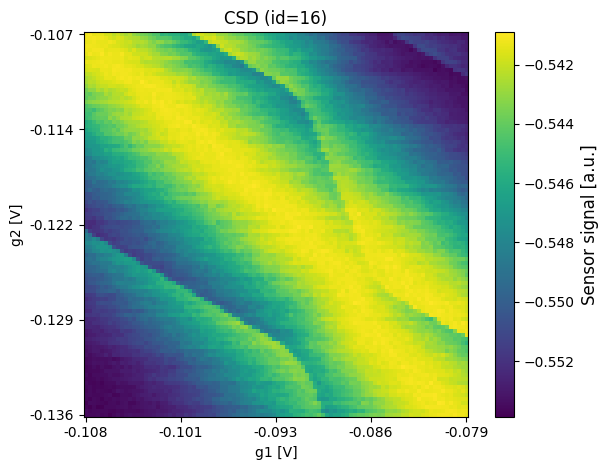

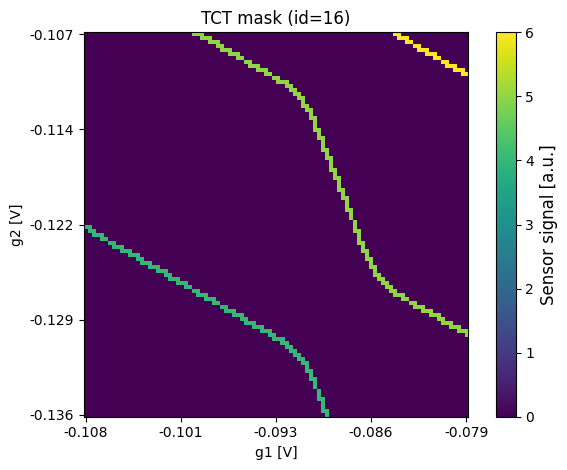

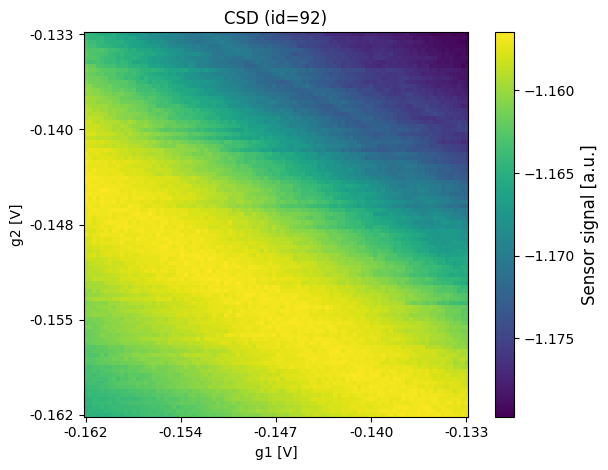

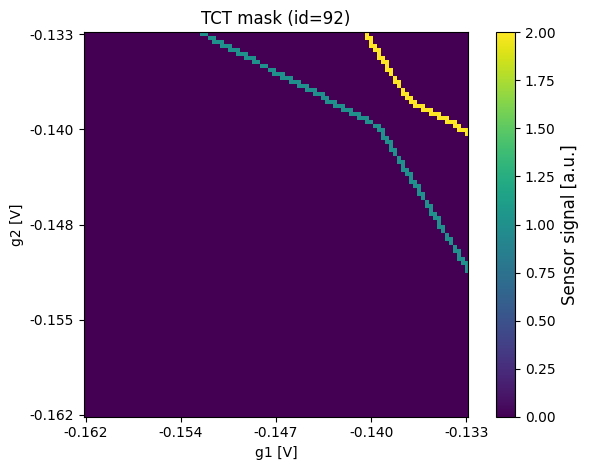

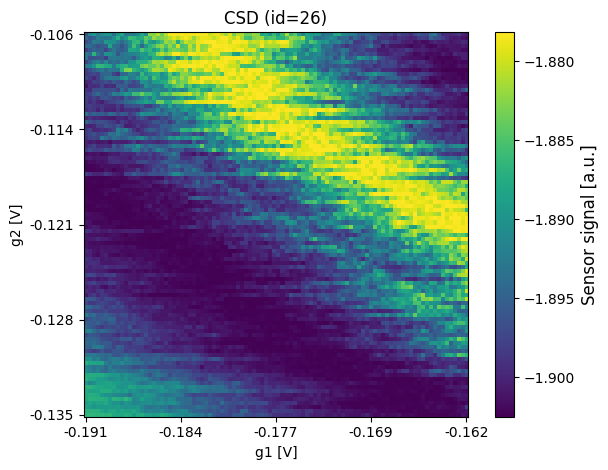

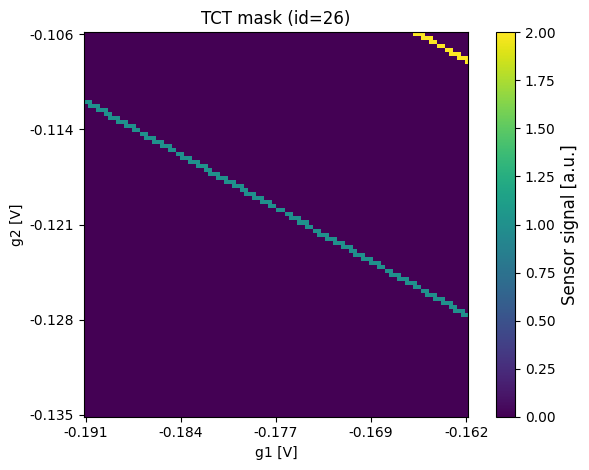

In [20]:
if not only_debug_plots:
    specific_ids = np.random.choice(a=np.arange(num_configs*num_samples_per_config), size=3, replace=False)
    ds = load_dataset(file=ds_path, load_ids=True, load_tct_masks=True, load_metadata=True, specific_ids=specific_ids)
    for _id, csd, tct, metadata in zip(ds.ids, ds.csds, ds.tct_masks, ds.metadata):
        v_1 = metadata["sweep_range_g1"]
        v_2 = metadata["sweep_range_g2"]
        plot_csd(csd, v_1, v_2, title=f"CSD (id={_id})")
        plot_csd(tct, v_1, v_2, title=f"TCT mask (id={_id})")